# 1. EDA and Preprocessing
Validation, 레이블별 약 7k에 대해서만 작업 대상으로 한정

In [22]:
import os
import shutil
import time
import zipfile
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

import tensorflow as tf
import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 933120000
from tqdm import tqdm
tqdm.pandas()

### 1. PATH

In [169]:
ROOT = r"E:\한국인 감정인식을 위한 복합 영상"
Validation_Path = r"Validation"

### 2. Zip Extract
다운 받은 데이터 셋은, 카이스트에서 구축한 데이터 셋으로  
한글 인코딩을 통해 압축을 해제 할 수 있음 (7개 레이블, 약 100Gb)

In [ ]:
# 한국어 인코딩 저용 후, 압축 해제
def unzip_kor(source_file: str, dest_path: str)->None:
    with zipfile.ZipFile(source_file, "r") as zf:
        zipInfo = zf.infolist()
        for member in zipInfo:
            member.filename = member.filename.encode("cp437").decode("euc-kr")
            zf.extract(member, dest_path)
            
val_label_list = [label for label in os.listdir(os.path.join(ROOT, Validation_Path)) if "[라벨]" in label]
val_source_list = [source for source in os.listdir(os.path.join(ROOT, Validation_Path)) if "[원천]" in source]

for zip_path in tqdm(test_label_list):
    zip_path = os.path.join(ROOT, Validation_Path, zip_path)
    unzip_kor(zip_path, os.path.join(ROOT, Validation_Path))
for zip_path in tqdm(test_source_list):
    dir_name = zip_path[11:13]
    zip_path = os.path.join(ROOT, Validation_Path, zip_path)
    unzip_kor(zip_path, os.path.join(ROOT, Validation_Path))

### 3. Load

#### Json 데이터

In [5]:
# JSON 데이터
total = [label for label in os.listdir(os.path.join(ROOT, Validation_Path)) if "[라벨]" in label]
dir_label = [label for label in total if "zip" not in label]

json_df = []
for json_data in dir_label:
    json_data = os.path.join(ROOT, Validation_Path, json_data)
    with open(os.path.join(json_data, os.listdir(json_data)[0])) as jFile:
        json_df.append(pd.DataFrame(json.load(jFile)))
json_df = pd.concat(json_df, axis=0).reset_index(drop=True)

#### 이미지 데이터

In [6]:
# 이미지 데이터
total = [img for img in os.listdir(os.path.join(ROOT, Validation_Path)) if "[원천]" in img]
dir_img = [img for img in total if "zip" not in img]

img_df = []
for img in dir_img:
    path = os.path.join(ROOT, Validation_Path, img)
    img_df.append(pd.DataFrame({"PATH":os.listdir(path)}))
img_df = pd.concat(img_df, axis=0).reset_index(drop=True)

#### Mapping

In [7]:
mapping_df = pd.merge(
    left=img_df, right=json_df, how="inner",
    left_on=["PATH"], right_on=["filename"]
)[["PATH", "gender", "age", "faceExp_uploader", "annot_A", "annot_B", "annot_C"]]

### 4. Preprocessing for COCO format

#### 4-1. 원본 이미지 사이즈 가져오기 및 이미지 사이즈 변경

In [9]:
# 1. 원본 이미지 사이즈 가져오기 및 이미지 사이즈 변경 (640, 640)
cnt = 0
def get_img_size(cols):
    global cnt
    path, label = cols[0], cols[1]
    dirL = [dirL for dirL in dir_img if label in dirL][0]
    try:
        path = os.path.join(ROOT, Validation_Path, dirL, path)
        img = Image.open(path)
        osize = img.size # 원본 이미지 사이즈
        img = img.resize((640, 640)) # 이미지 사이즈 변경
        img.save(path)
        return osize
    except: print(path)
    
mapping_df["SIZE"] = mapping_df[["PATH", "faceExp_uploader"]].progress_apply(get_img_size, axis=1)

100%|██████████| 52139/52139 [2:34:39<00:00,  5.62it/s]  


In [24]:
# 원본 가로
mapping_df["O_W"] = mapping_df["SIZE"].apply(lambda s: str(s).strip("(|)").split(",")[0])
# 원본 가로
mapping_df["O_H"] = mapping_df["SIZE"].apply(lambda s: str(s).strip("(|)").split(",")[1])

#### 4-2. Annotate 정보 가져오기

In [11]:
# 2. Annot 정보 가져오기
def get_Annot(annot):
    annot = dict(annot)
    return dict(annot["boxes"])

mapping_df["annot_A"] = mapping_df["annot_A"].progress_apply(get_Annot)
mapping_df["annot_B"] = mapping_df["annot_B"].progress_apply(get_Annot)
mapping_df["annot_C"] = mapping_df["annot_C"].progress_apply(get_Annot)

100%|██████████| 52139/52139 [00:00<00:00, 1063770.83it/s]


In [53]:
def get_maxX(annot): return annot["maxX"]
def get_maxY(annot): return annot["maxY"]
def get_minX(annot): return annot["minX"]
def get_minY(annot): return annot["minY"]

mapping_df["A_maxX"] = mapping_df["annot_A"].apply(get_maxX)
mapping_df["A_maxY"] = mapping_df["annot_A"].apply(get_maxY)
mapping_df["A_minX"] = mapping_df["annot_A"].apply(get_minX)
mapping_df["A_minY"] = mapping_df["annot_A"].apply(get_minY)

mapping_df["B_maxX"] = mapping_df["annot_B"].apply(get_maxX)
mapping_df["B_maxY"] = mapping_df["annot_B"].apply(get_maxY)
mapping_df["B_minX"] = mapping_df["annot_B"].apply(get_minX)
mapping_df["B_minY"] = mapping_df["annot_B"].apply(get_minY)

mapping_df["C_maxX"] = mapping_df["annot_C"].apply(get_maxX)
mapping_df["C_maxY"] = mapping_df["annot_C"].apply(get_maxY)
mapping_df["C_minX"] = mapping_df["annot_C"].apply(get_minX)
mapping_df["C_minY"] = mapping_df["annot_C"].apply(get_minY)

#### 4-3. Normalization

In [63]:
def normalization(cols): return float(cols[0]) / float(cols[1])

mapping_df["nor_A_maxX"] = mapping_df[["A_maxX", "O_W"]].apply(normalization, axis=1)
mapping_df["nor_A_maxY"] = mapping_df[["A_maxY", "O_H"]].apply(normalization, axis=1)
mapping_df["nor_A_minX"] = mapping_df[["A_minX", "O_W"]].apply(normalization, axis=1)
mapping_df["nor_A_minY"] = mapping_df[["A_minY", "O_H"]].apply(normalization, axis=1)

mapping_df["nor_B_maxX"] = mapping_df[["B_maxX", "O_W"]].apply(normalization, axis=1)
mapping_df["nor_B_maxY"] = mapping_df[["B_maxY", "O_H"]].apply(normalization, axis=1)
mapping_df["nor_B_minX"] = mapping_df[["B_minX", "O_W"]].apply(normalization, axis=1)
mapping_df["nor_B_minY"] = mapping_df[["B_minY", "O_H"]].apply(normalization, axis=1)

mapping_df["nor_C_maxX"] = mapping_df[["C_maxX", "O_W"]].apply(normalization, axis=1)
mapping_df["nor_C_maxY"] = mapping_df[["C_maxY", "O_H"]].apply(normalization, axis=1)
mapping_df["nor_C_minX"] = mapping_df[["C_minX", "O_W"]].apply(normalization, axis=1)
mapping_df["nor_C_minY"] = mapping_df[["C_minY", "O_H"]].apply(normalization, axis=1)

#### 4-4. Calculate X Y W H

In [96]:
def get_XorY(cols): return (cols[0]+cols[1])/2.0
def get_WorH(cols): return cols[1] - cols[0]

mapping_df["AX"] = mapping_df[["nor_A_minX", "nor_A_maxX"]].apply(get_XorY, axis=1)
mapping_df["AY"] = mapping_df[["nor_A_minY", "nor_A_maxY"]].apply(get_XorY, axis=1)
mapping_df["AW"] = mapping_df[["nor_A_minX", "nor_A_maxX"]].apply(get_WorH, axis=1)
mapping_df["AH"] = mapping_df[["nor_A_minY", "nor_A_maxY"]].apply(get_WorH, axis=1)

mapping_df["BX"] = mapping_df[["nor_B_minX", "nor_B_maxX"]].apply(get_XorY, axis=1)
mapping_df["BY"] = mapping_df[["nor_B_minY", "nor_B_maxY"]].apply(get_XorY, axis=1)
mapping_df["BW"] = mapping_df[["nor_B_minX", "nor_B_maxX"]].apply(get_WorH, axis=1)
mapping_df["BH"] = mapping_df[["nor_B_minY", "nor_B_maxY"]].apply(get_WorH, axis=1)

mapping_df["CX"] = mapping_df[["nor_C_minX", "nor_C_maxX"]].apply(get_XorY, axis=1)
mapping_df["CY"] = mapping_df[["nor_C_minY", "nor_C_maxY"]].apply(get_XorY, axis=1)
mapping_df["CW"] = mapping_df[["nor_C_minX", "nor_C_maxX"]].apply(get_WorH, axis=1)
mapping_df["CH"] = mapping_df[["nor_C_minY", "nor_C_maxY"]].apply(get_WorH, axis=1)

#### 4-5. Plot Sample

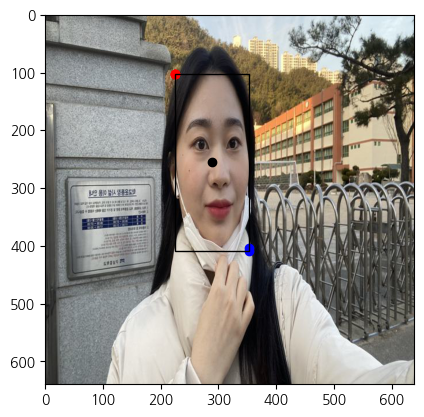

In [95]:
import matplotlib.patches as patches

fig, ax = plt.subplots()

img = plt.imread(os.path.join(ROOT, Validation_Path, "[원천]EMOIMG_기쁨_VALID", mapping_df.iloc[0]["PATH"]))

plt.scatter(float(mapping_df.iloc[0]["nor_A_minX"])*640, float(mapping_df.iloc[0]["nor_A_minY"])*640, color="r")
plt.scatter(float(mapping_df.iloc[0]["nor_A_maxX"])*640, float(mapping_df.iloc[0]["nor_A_maxY"])*640, color="b")
plt.scatter(float(mapping_df.iloc[0]["nor_B_minX"])*640, float(mapping_df.iloc[0]["nor_B_minY"])*640, color="r")
plt.scatter(float(mapping_df.iloc[0]["nor_B_maxX"])*640, float(mapping_df.iloc[0]["nor_B_maxY"])*640, color="b")
plt.scatter(float(mapping_df.iloc[0]["nor_C_minX"])*640, float(mapping_df.iloc[0]["nor_C_minY"])*640, color="r")

plt.scatter(mapping_df.iloc[0]["AX"]*640, mapping_df.iloc[0]["AY"]*640, color="black")
ax.add_patch(
    patches.Rectangle(
        (float(mapping_df.iloc[0]["nor_A_minX"])*640, float(mapping_df.iloc[0]["nor_A_minY"])*640),
        mapping_df.iloc[0]["AW"]*640, mapping_df.iloc[0]["AH"]*640, fill=False, edgecolor="black"
    )
)

plt.imshow(img)
plt.show()

### 5. EDA

In [105]:
pass

### 6. Label Selection

In [104]:
pass

### 7. Mov and Formatted

In [110]:
# get YOLO
# !git clone https://github.com/ultralytics/yolov5
YOLO_DATA_PATH = r"E:\Avg26_Personal_Color_Performance\models\Emotion Estimate\yolov5\data\images"

label_dict = {"기쁨":0, "당황":1, "불안":1, "분노":2, "상처":3, "슬픔":3, "중립":4}

In [111]:
y_df = mapping_df[["PATH", "faceExp_uploader", "AX", "AY", "AW", "AH"]].copy()

In [149]:
TRAIN_SIZE = 6290
VAL_SIZE = 1110

train_df = []
val_df = []
for label in label_dict.keys():
    label_df = y_df[y_df["faceExp_uploader"]==label]
    if label in ["당황", "불안", "상처", "슬픔"]:
        train_df.append(label_df.sample(n=int(TRAIN_SIZE/2), replace=False))
        val_df.append(label_df.sample(n=int(VAL_SIZE/2), replace=False))
    else:
        train_df.append(label_df.sample(n=TRAIN_SIZE, replace=False))
        val_df.append(label_df.sample(n=VAL_SIZE, replace=False))
        
train_df = pd.concat(train_df, axis=0)
val_df = pd.concat(val_df, axis=0)

In [174]:
def cp_and_add_txt(cols):
    path, label, x, y, w, h = cols
    dirL = [dirL for dirL in dir_img if label in dirL][0]
    txt = path.split(".")[0]
    # 파일 복사
    shutil.copy(os.path.join(ROOT, Validation_Path, dirL, path), os.path.join(YOLO_DATA_PATH, "Train", path))
    # txt 파일 생성
    with open(os.path.join(YOLO_DATA_PATH, "Train", txt+".txt"), "w") as txt:
        txt.write(f"{label_dict[label]} {x} {y} {w} {h}")
        
train_df.progress_apply(cp_and_add_txt, axis=1)

100%|██████████| 31450/31450 [26:52<00:00, 19.51it/s]  


3641     None
1057     None
2808     None
3480     None
4235     None
         ... 
47652    None
47789    None
48078    None
48518    None
46336    None
Length: 31450, dtype: object

In [175]:
def cp_and_add_txt(cols):
    path, label, x, y, w, h = cols
    dirL = [dirL for dirL in dir_img if label in dirL][0]
    txt = path.split(".")[0]
    # 파일 복사
    shutil.copy(os.path.join(ROOT, Validation_Path, dirL, path), os.path.join(YOLO_DATA_PATH, "Val", path))
    # txt 파일 생성
    with open(os.path.join(YOLO_DATA_PATH, "Val", txt+".txt"), "w") as txt:
        txt.write(f"{label_dict[label]} {x} {y} {w} {h}")
        
val_df.progress_apply(cp_and_add_txt, axis=1)

100%|██████████| 5550/5550 [05:17<00:00, 17.47it/s]


5369     None
4724     None
6319     None
1853     None
2326     None
         ... 
50589    None
51345    None
49018    None
49768    None
44816    None
Length: 5550, dtype: object